In [20]:
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams

rcParams["savefig.dpi"] = 50
rcParams["figure.dpi"] = 50
rcParams["font.size"] = 15

In [21]:
import numpy as np

def log_prob(x, mu, cov):
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

ndim = 5

np.random.seed(42)
means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim**2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov, cov)

In [22]:
nwalkers = 48
p0 = np.random.rand(nwalkers, ndim)

import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

log_prob(p0[0], means, cov)

-2.596094589085444

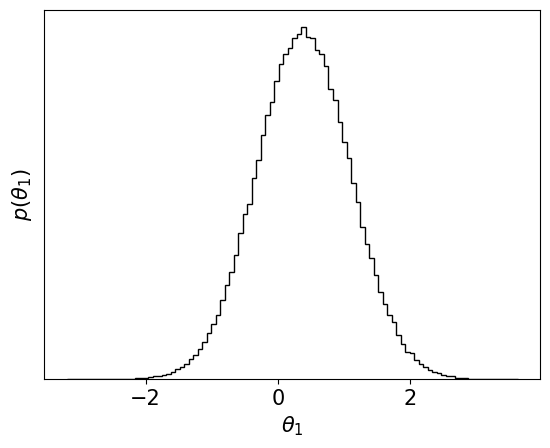

In [23]:
state = sampler.run_mcmc(p0, 200)
sampler.reset()

sampler.run_mcmc(state, 20000);

import matplotlib.pyplot as plt

samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

In [24]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean acceptance fraction: 0.552
Mean autocorrelation time: 55.718 steps


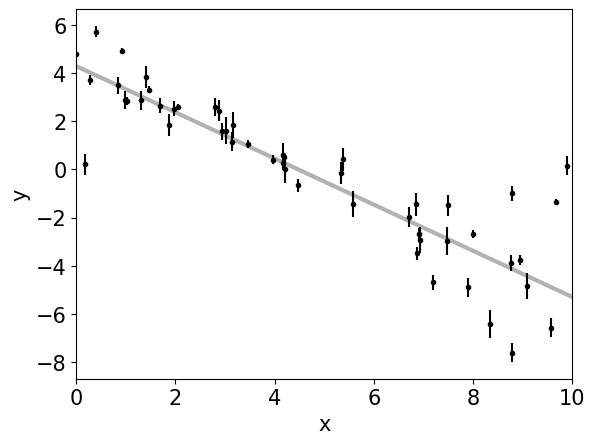

In [25]:
np.random.seed(1)

# Choose the "true" parameters.
m_true = -0.9594 # slope
b_true = 4.294 # y-intercept
f_true = 0.534 # constant uncertainty underestimation value

# Generate some synthetic data from the model.
N = 50 # number of points
x = np.sort(10 * np.random.rand(N)) # x values
yerr = 0.1 + 0.5 * np.random.rand(N) # error values
y = m_true * x + b_true # y values
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Least-squares estimates:
m = -0.795 ± 0.010
b = 4.284 ± 0.054


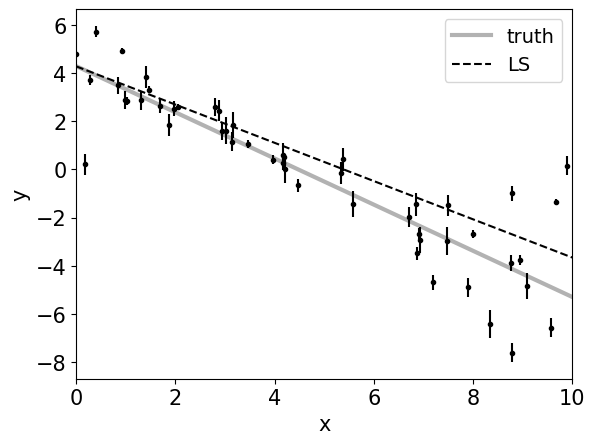

In [26]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Maximum likelihood estimates:
m = -0.991
b = 4.382
f = 0.414


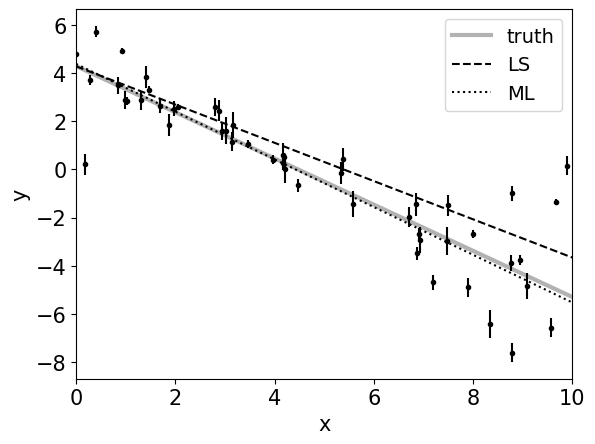

In [27]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [28]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:05<00:00, 851.74it/s]


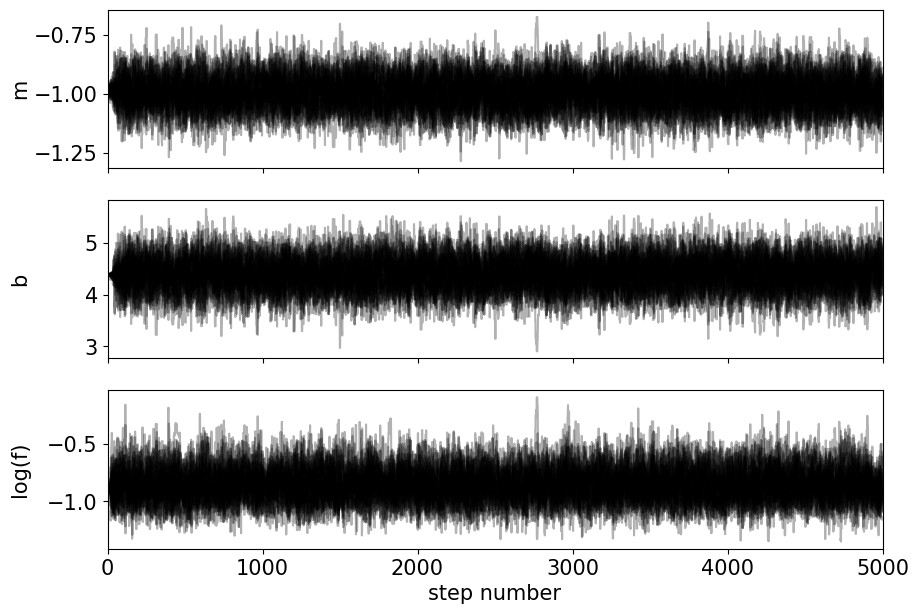

In [29]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [30]:
tau = sampler.get_autocorr_time()
print(tau)

[35.71113168 34.75945134 38.05883058]


In [31]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


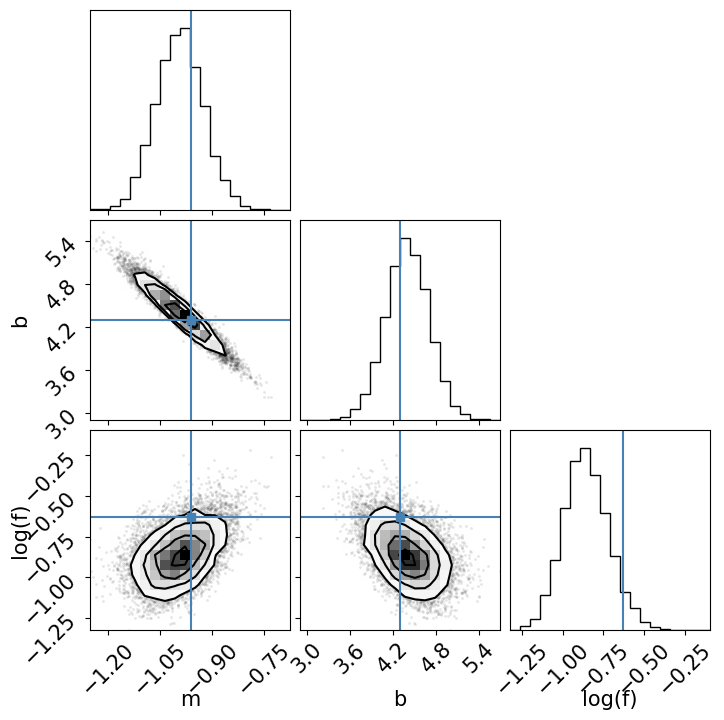

In [32]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

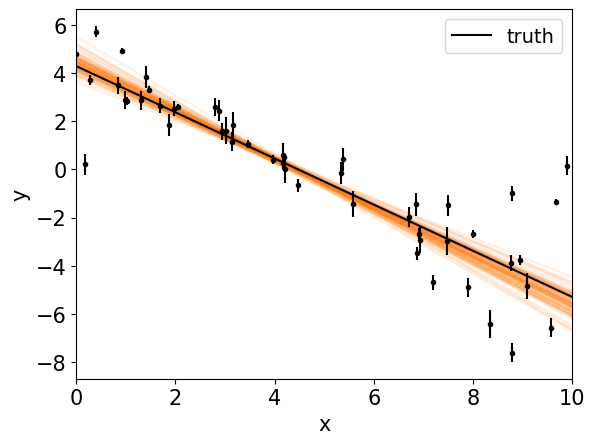

In [33]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [34]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>